In [43]:
!pip install pillow

In [44]:
# Gerekli kütüphaneleri yükleyin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import os
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from google.colab import files




In [3]:
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:29<00:00, 79.2MB/s]
100% 2.29G/2.29G [00:29<00:00, 84.5MB/s]


In [6]:
import zipfile

# İndirilen zip dosyasını ayıklayın
with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('chest_xray')


In [36]:
import os

# Veri setinin dizin yapısını görüntüleyin
for dirname, _, filenames in os.walk('chest_xray'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



Görüntülenen çıkış son 5000 satıra kısaltıldı.
chest_xray/chest_xray/chest_xray/train/PNEUMONIA/person29_bacteria_144.jpeg
chest_xray/chest_xray/chest_xray/train/PNEUMONIA/person741_virus_1364.jpeg
chest_xray/chest_xray/chest_xray/train/PNEUMONIA/person1273_bacteria_3233.jpeg
chest_xray/chest_xray/chest_xray/train/PNEUMONIA/person126_virus_255.jpeg
chest_xray/chest_xray/chest_xray/train/PNEUMONIA/person1295_bacteria_3258.jpeg
chest_xray/chest_xray/chest_xray/train/PNEUMONIA/person36_bacteria_183.jpeg
chest_xray/chest_xray/chest_xray/train/PNEUMONIA/person896_bacteria_2821.jpeg
chest_xray/chest_xray/chest_xray/train/PNEUMONIA/person354_bacteria_1634.jpeg
chest_xray/chest_xray/chest_xray/train/PNEUMONIA/person35_bacteria_178.jpeg
chest_xray/chest_xray/chest_xray/train/PNEUMONIA/person1310_bacteria_3304.jpeg
chest_xray/chest_xray/chest_xray/train/PNEUMONIA/person913_bacteria_2838.jpeg
chest_xray/chest_xray/chest_xray/train/PNEUMONIA/person445_virus_913.jpeg
chest_xray/chest_xray/chest_xra

In [37]:
# Veri setinin yolu
base_dir = 'chest_xray/chest_xray/chest_xray/'

# Eğitim, doğrulama ve test setlerinin yolunu belirleme
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Eğitim setindeki örnek sayısını kontrol edelim
train_normal = os.listdir(os.path.join(train_dir, 'NORMAL'))
train_pneumonia = os.listdir(os.path.join(train_dir, 'PNEUMONIA'))

print(f'Normal Eğitim Görüntüleri: {len(train_normal)}')
print(f'Pneumonia Eğitim Görüntüleri: {len(train_pneumonia)}')


Normal Eğitim Görüntüleri: 1342
Pneumonia Eğitim Görüntüleri: 3876


In [53]:
def count_images(directory):
    # Sınıfların listesi
    classes = ['NORMAL', 'PNEUMONIA']

    # Her sınıf için görüntü sayısını tutacak sözlük
    class_counts = {cls: 0 for cls in classes}

    # Her sınıfın dizinini dolaşarak görüntü sayısını hesapla
    for cls in classes:
        class_path = os.path.join(directory, cls)
        class_count = len(os.listdir(class_path))
        class_counts[cls] = class_count

    return class_counts

# Eğitim seti için sınıf sayıları
train_class_counts = count_images(train_dir)

# Doğrulama seti için sınıf sayıları
val_class_counts = count_images(val_dir)

# Test seti için sınıf sayıları
test_class_counts = count_images(test_dir)

# Sonuçları yazdırma
print("Eğitim Seti:")
print(f"NORMAL: {train_class_counts['NORMAL']}")
print(f"PNEUMONIA: {train_class_counts['PNEUMONIA']}")
print()
print("Doğrulama Seti:")
print(f"NORMAL: {val_class_counts['NORMAL']}")
print(f"PNEUMONIA: {val_class_counts['PNEUMONIA']}")
print()
print("Test Seti:")
print(f"NORMAL: {test_class_counts['NORMAL']}")
print(f"PNEUMONIA: {test_class_counts['PNEUMONIA']}")

Eğitim Seti:
NORMAL: 1342
PNEUMONIA: 3876

Doğrulama Seti:
NORMAL: 9
PNEUMONIA: 9

Test Seti:
NORMAL: 234
PNEUMONIA: 390


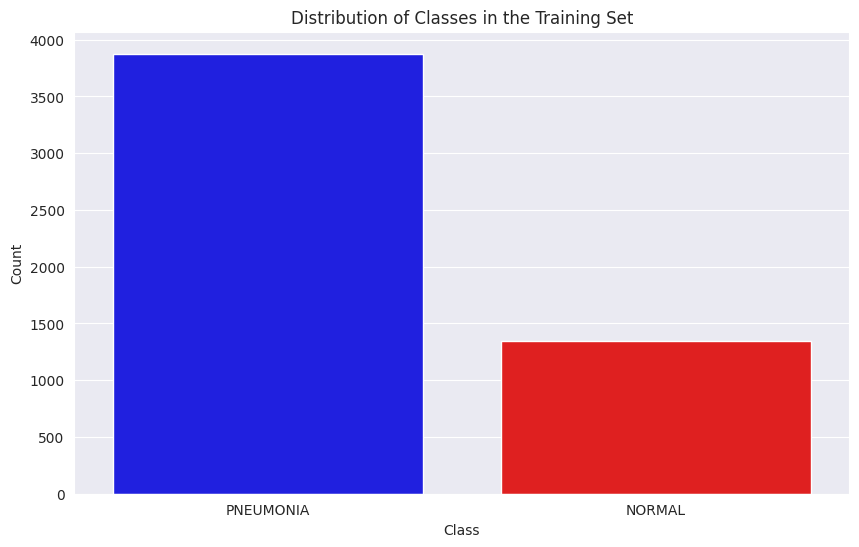

In [96]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Eğitim veri setindeki etiketleri içeren bir liste oluşturma
l = []
for root, dirs, files in os.walk(train_dir):
    for dir in dirs:
        if dir == 'PNEUMONIA':
            l.extend(["PNEUMONIA"] * len(os.listdir(os.path.join(root, dir)))) # Add 'PNEUMONIA' for each file in the directory
        elif dir == 'NORMAL':
            l.extend(["NORMAL"] * len(os.listdir(os.path.join(root, dir)))) # Add 'NORMAL' for each file in the directory

# Listeyi pandas Series'e dönüştürme
l_series = pd.Series(l)

# seaborn kullanarak countplot çizme
sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))  # Grafiğin boyutunu belirleme
sns.countplot(x=l_series, hue=l_series, palette=['blue', 'red'], legend=False)  # Mavi ve kırmızı renkleri belirleme, uyarıyı giderme
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes in the Training Set')
plt.show()

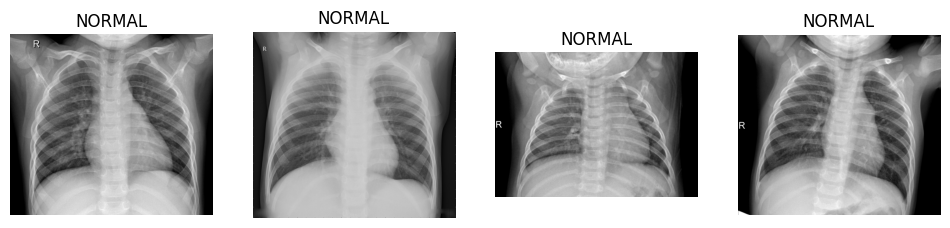

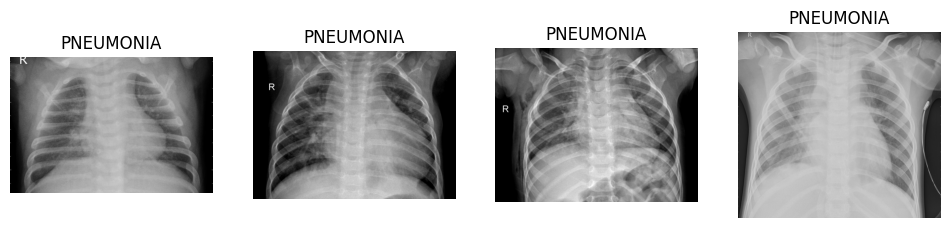

In [38]:
def show_sample_images(directory, category, num_images=4):
    category_dir = os.path.join(directory, category)
    images = os.listdir(category_dir)
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        img_path = os.path.join(category_dir, images[i])
        img = load_img(img_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(category)
    plt.show()

show_sample_images(train_dir, 'NORMAL')
show_sample_images(train_dir, 'PNEUMONIA')


In [45]:
# Görselleri yükleme ve ön işleme fonksiyonu
def load_data(directory):
    images = []
    labels = []
    for label in ['NORMAL', 'PNEUMONIA']:
        path = os.path.join(directory, label)
        for img in tqdm(os.listdir(path)):
            img_path = os.path.join(path, img)
            # Check if the file is a valid image file
            try:
                # Attempt to open the image file
                with Image.open(img_path) as im:
                    # If successful, proceed with loading and processing
                    img = load_img(img_path, target_size=(150, 150))
                    img = img_to_array(img)
                    img = img / 255.0
                    images.append(img)
                    labels.append(0 if label == 'NORMAL' else 1)
            except IOError:
                print(f"Cannot identify image file: {img_path}")
    return np.array(images), np.array(labels)

# Eğitim, doğrulama ve test verilerini yükleyin
train_images, train_labels = load_data(train_dir)
val_images, val_labels = load_data(val_dir)
test_images, test_labels = load_data(test_dir)




 52%|█████▏    | 693/1342 [00:24<00:12, 53.38it/s]

Cannot identify image file: chest_xray/chest_xray/chest_xray/train/NORMAL/.DS_Store


 52%|█████▏    | 2020/3876 [00:14<00:12, 153.04it/s]

Cannot identify image file: chest_xray/chest_xray/chest_xray/train/PNEUMONIA/.DS_Store


100%|██████████| 9/9 [00:00<00:00, 86.55it/s]


Cannot identify image file: chest_xray/chest_xray/chest_xray/val/NORMAL/.DS_Store


100%|██████████| 9/9 [00:00<00:00, 179.70it/s]


Cannot identify image file: chest_xray/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store


100%|██████████| 390/390 [00:03<00:00, 111.18it/s]


# **CNN Tanımlama**

In [55]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_3 (Flatten)         (None, 82944)             0         
                                                                 
 dense_6 (Dense)             (None, 128)              

# **Veri Artırma ile Eğitim Verilerini Hazırlama**

In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Veri artırma ve normalizasyon işlemleri
image_size = (150, 150)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Eğitim, doğrulama ve test setleri için generator oluşturma
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# **Modeli Eğitme**

In [57]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping ve model checkpoint tanımlaması
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Model eğitimi
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=9,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/20
163/163 [==============================] - ETA: 0s - loss: 0.5349 - accuracy: 0.7740

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


163/163 [==============================] - 299s 2s/step - loss: 0.5349 - accuracy: 0.7740 - val_loss: 0.9018 - val_accuracy: 0.6250
Epoch 2/20
163/163 [==============================] - 259s 2s/step - loss: 0.3583 - accuracy: 0.8363 - val_loss: 1.1345 - val_accuracy: 0.6250
Epoch 3/20
163/163 [==============================] - 261s 2s/step - loss: 0.3212 - accuracy: 0.8579 - val_loss: 0.7836 - val_accuracy: 0.6250
Epoch 4/20
163/163 [==============================] - 264s 2s/step - loss: 0.3009 - accuracy: 0.8685 - val_loss: 0.9399 - val_accuracy: 0.6250
Epoch 5/20
163/163 [==============================] - 258s 2s/step - loss: 0.2878 - accuracy: 0.8775 - val_loss: 0.5675 - val_accuracy: 0.8125
Epoch 6/20
163/163 [==============================] - 286s 2s/step - loss: 0.2767 - accuracy: 0.8834 - val_loss: 0.4522 - val_accuracy: 0.8750
Epoch 7/20
163/163 [==============================] - 274s 2s/step - loss: 0.2546 - accuracy: 0.8911 - val_loss: 0.8870 - val_accuracy: 0.6875
Epoch 8/20

In [58]:
# Test seti üzerinde modelin değerlendirilmesi
print("Test seti üzerinde modelin değerlendirilmesi:")
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_acc}")

Test seti üzerinde modelin değerlendirilmesi:
20/20 [==============================] - 10s 456ms/step - loss: 0.3120 - accuracy: 0.8830
Test Accuracy: 0.8830128312110901


In [59]:
# Confusion matrix ve sınıflandırma raporu
test_generator.reset()
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred = np.round(y_pred)  # Tahminleri 0 veya 1'e yuvarla

20/20 [==============================] - 10s 471ms/step


In [60]:
# Gerçek etiketler
y_true = test_generator.classes

In [61]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[195  39]
 [ 34 356]]


In [62]:
# Sınıflandırma raporu
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.85      0.83      0.84       234
   PNEUMONIA       0.90      0.91      0.91       390

    accuracy                           0.88       624
   macro avg       0.88      0.87      0.87       624
weighted avg       0.88      0.88      0.88       624



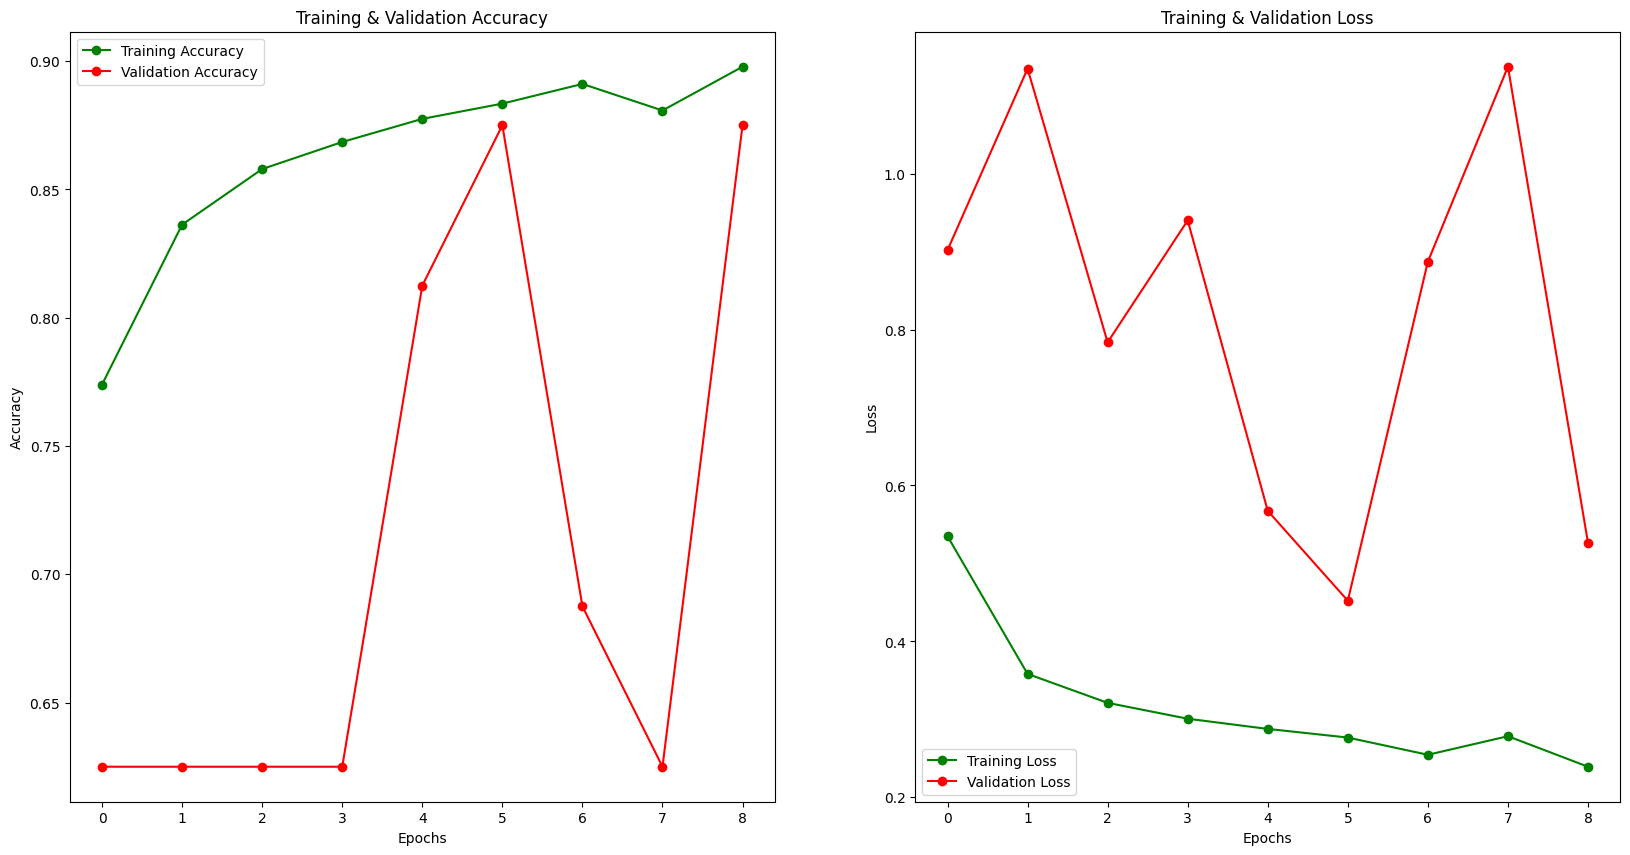

In [67]:
epochs = [i for i in range(len(history.history['accuracy']))]  # Eğitimde kullanılan epoch sayısını otomatik olarak belirler
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20, 10)

# Eğitim ve doğrulama doğruluğunun grafiği
ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

# Eğitim ve doğrulama kayıplarının grafiği
ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()


In [75]:
# Test verileri üzerindeki tahminleri al
test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
predictions = np.round(predictions).astype(int).reshape(-1)

20/20 [==============================] - 16s 659ms/step


In [76]:
# İlk 15 tahmini göster
print(predictions[:15])

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


In [77]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Sınıflandırma raporu
print(classification_report(y_true, predictions, target_names=['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.85      0.83      0.84       234
   Normal (Class 1)       0.90      0.91      0.91       390

           accuracy                           0.88       624
          macro avg       0.88      0.87      0.87       624
       weighted avg       0.88      0.88      0.88       624



In [78]:
# Karışıklık matrisi
cm = confusion_matrix(y_true, predictions)
cm_df = pd.DataFrame(cm, index=['Pneumonia (Class 0)','Normal (Class 1)'], columns=['Pneumonia (Class 0)','Normal (Class 1)'])


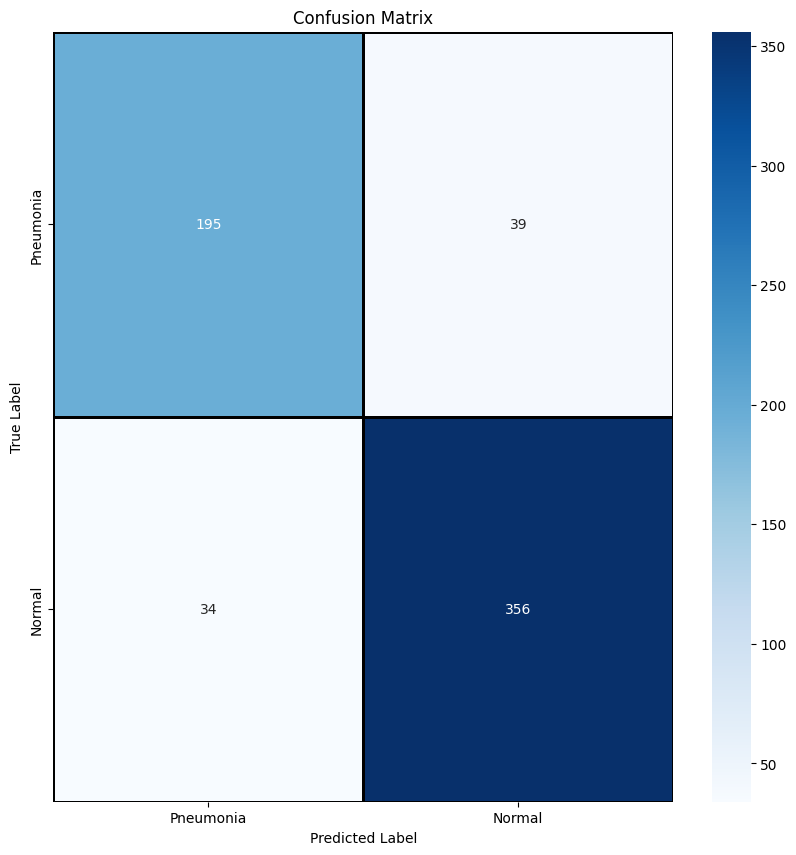

In [79]:
# Karışıklık matrisini görselleştirme
plt.figure(figsize=(10, 10))
sns.heatmap(cm_df, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=['Pneumonia', 'Normal'], yticklabels=['Pneumonia', 'Normal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [80]:
# Doğru ve yanlış tahmin edilen örneklerin görselleştirilmesi
correct = np.nonzero(predictions == y_true)[0]
incorrect = np.nonzero(predictions != y_true)[0]

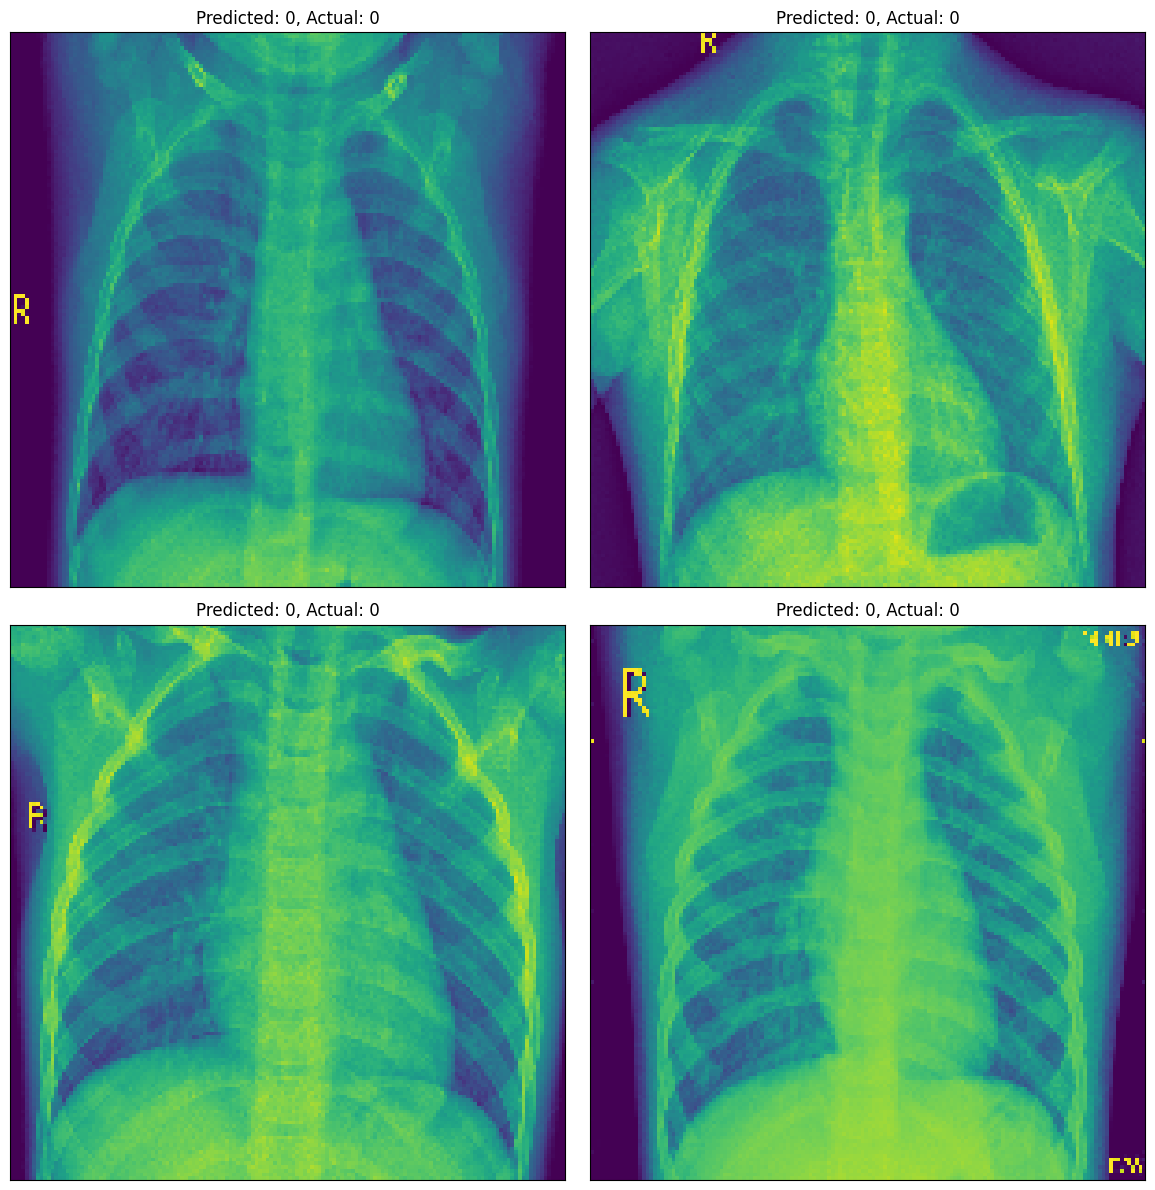

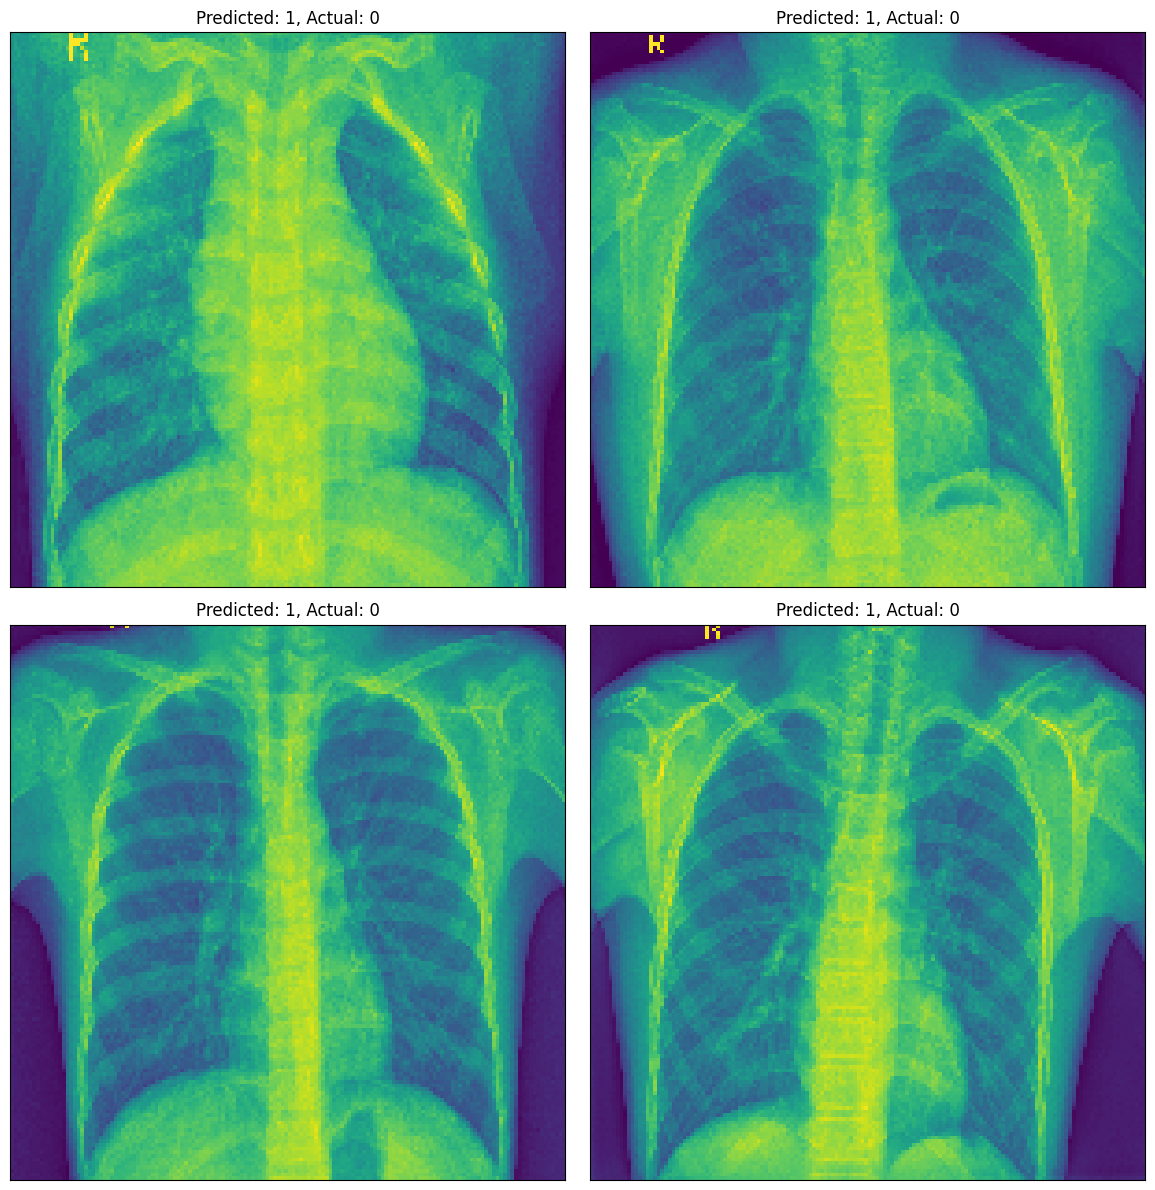

In [86]:
# Doğru tahmin edilen ilk 4 örnek
plt.figure(figsize=(12, 12))
for i, c in enumerate(correct[:4]):
    plt.subplot(2, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    # Resim piksellerini normalize et
    normalized_image = (test_images[c] - np.min(test_images[c])) / (np.max(test_images[c]) - np.min(test_images[c]))
    # İlk renk kanalını seç ve görüntüle
    plt.imshow(normalized_image[:, :, 0], cmap="viridis", interpolation="nearest")
    plt.title(f"Predicted: {predictions[c]}, Actual: {y_true[c]}")
    plt.tight_layout()
plt.show()

# Yanlış tahmin edilen ilk 4 örnek
plt.figure(figsize=(12, 12))
for i, c in enumerate(incorrect[:4]):
    plt.subplot(2, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    # Resim piksellerini normalize et
    normalized_image = (test_images[c] - np.min(test_images[c])) / (np.max(test_images[c]) - np.min(test_images[c]))
    # İlk renk kanalını seç ve görüntüle
    plt.imshow(normalized_image[:, :, 0], cmap="viridis", interpolation="nearest")
    plt.title(f"Predicted: {predictions[c]}, Actual: {y_true[c]}")
    plt.tight_layout()
plt.show()
